In [17]:
%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from scipy.stats import entropy
import copy

import itertools
import time
from tqdm import tqdm_notebook as tqdm

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
from torch.utils.data.dataset import Dataset

class MovingMNIST(Dataset):
    def __init__(self, dataset , transform = None ):
      
        self.data = dataset.f.arr_0.transpose(0,3,2,1)
      
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.data[index]
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self): 
          return len(self.data)

In [19]:
class VAE_Encoder(nn.Module):
    def __init__(self, k):
        super(VAE_Encoder, self).__init__()
        intermediate_channels = 128
        z_dims = k
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(64, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=False)

        
        self.conv_mu = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        self.conv_logvar = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        
 
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(intermediate_channels)
        
    def forward(self, x):
      
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)

        return mu, logvar
    def rsample(self, mu, logvar):
        m = torch.distributions.Normal(mu, torch.exp(logvar * 0.5))
        return m.rsample()
    
class VAE_Decoder(nn.Module):
    def __init__(self,k):
        super(VAE_Decoder, self).__init__()
        out_channels = 64
        self.conv1 = nn.ConvTranspose2d(k, out_channels, kernel_size=3, stride=2, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=0, bias=False)
        self.conv3 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=0,  bias=False)
        self.conv4 = nn.ConvTranspose2d(out_channels, 1, kernel_size=4, stride=2, padding=0, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(1)
        
        
    def forward(self, input):
#         print(input.shape)
        x = F.relu(self.bn1(self.conv1(input)))
#         print("Conv1",x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
#         print(x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
#         print(x.shape)
        x = self.bn4(self.conv4(x))
#         print(x.shape)
       
        return x


In [20]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        #TO-DO
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 5, stride=1, bias=False)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 5,stride=2,  bias=False)
        self.conv3 = nn.Conv2d(16, 1, kernel_size = 5,stride=2, bias=False)
        self.linear1 = nn.Linear(16 , 8)
        self.linear3 = nn.Linear(8 , 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(1)
        
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = F.relu(self.bn1((self.conv1(x))))  # 30 x 30
        x = F.relu(self.bn2(self.conv2(x)))   # 13x13
        l = self.conv3(x)
        x = F.relu(self.bn3(l)) # 5x5
        x = x.view(-1,16)
        x = F.relu(self.linear1(x))
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x[:,0] , l
        
        
        

        

In [21]:
train_data = np.load('train_data.npz')
train_dataset = MovingMNIST(train_data, 
                            transform=transforms.Compose([
                                transforms.ToPILImage(), 
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.04905,), (0.1992,))]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)

In [23]:
encoder = VAE_Encoder(100).to(device)
decoder = VAE_Decoder(100).to(device)
discriminator = Discriminator().to(device)

In [25]:
def loss_function_mse(real_l,fake_l):
    L2 = F.mse_loss(real_l, fake_l, reduction='sum')   
    return L2

def loss_function_kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  
    return KLD 

28.03770637512207 8936.9765625 257.48040771484375 0.3953592777252197


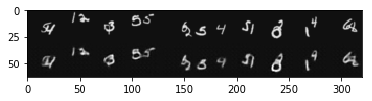

0.376979261636734 7972.55615234375 296.0965576171875 7.057361602783203


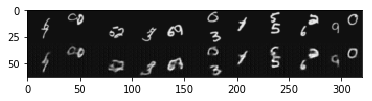

1.1603264808654785 7007.634765625 266.1076965332031 6.960996150970459


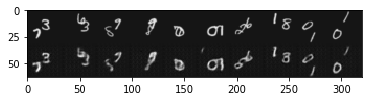

1.2183688879013062 6332.4697265625 225.99732971191406 6.9453394412994385


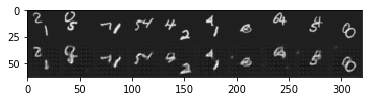

1.4101041555404663 5571.3427734375 207.8632354736328 6.963476181030273


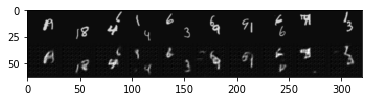

Epoch time  33.08259201049805
3.4696104526519775 5116.453125 242.3597412109375 0.49516844749450684


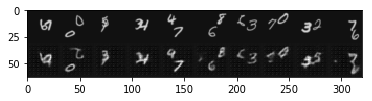

1.9448683261871338 4418.5009765625 200.3705291748047 7.162055969238281


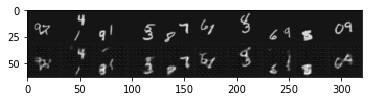

0.9278772473335266 3951.15478515625 191.0201873779297 6.945476770401001


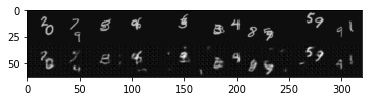

1.1392689943313599 3360.634521484375 183.06405639648438 6.957228422164917


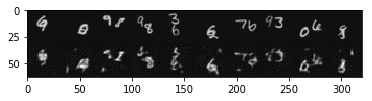

0.5354313850402832 2939.92236328125 179.59207153320312 6.972116470336914


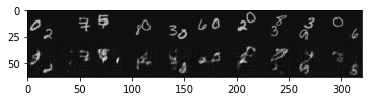

Epoch time  33.29585576057434
0.43221575021743774 2658.53857421875 179.72671508789062 0.4873383045196533


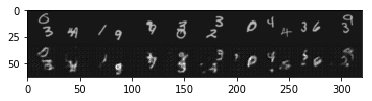

0.332452654838562 2178.85205078125 179.92396545410156 7.1379311084747314


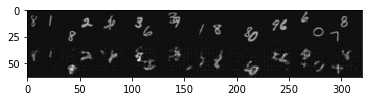

10.503279685974121 1856.26904296875 300.6201477050781 6.968380451202393


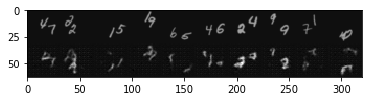

0.8215917348861694 1652.877685546875 180.8915557861328 6.976156711578369


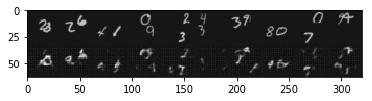

0.41887199878692627 1386.1112060546875 180.48660278320312 6.95795750617981


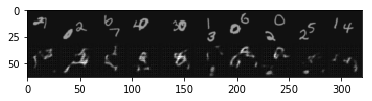

Epoch time  33.29230451583862
0.5844577550888062 1212.2071533203125 185.8618621826172 0.5251438617706299


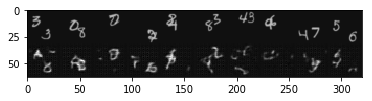

2.8248648643493652 1028.6920166015625 292.3101501464844 7.1356520652771


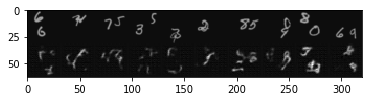

1.2019903659820557 911.4246826171875 202.13461303710938 6.968875408172607


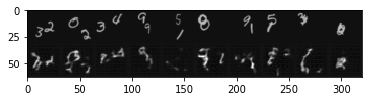

2.095341444015503 789.5044555664062 224.43157958984375 6.979902505874634


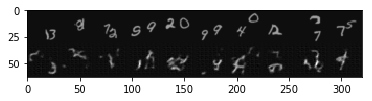

0.5493817329406738 683.5440673828125 192.8657989501953 7.068583726882935


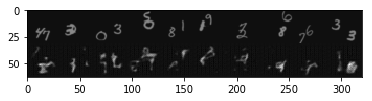

Epoch time  33.44427537918091
1.545526385307312 628.4528198242188 183.4393310546875 0.5888183116912842


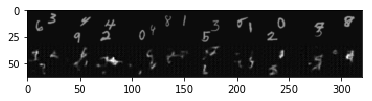

0.5025312900543213 573.0861206054688 181.93101501464844 7.087848901748657


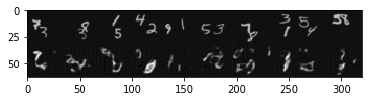

1.2644933462142944 461.5760192871094 179.92367553710938 6.976720094680786


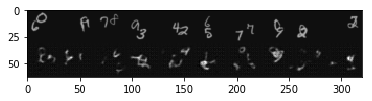

0.5110369920730591 428.7478942871094 182.66073608398438 6.984665632247925


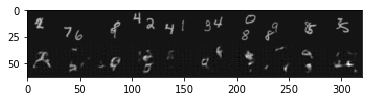

0.3841548264026642 383.45831298828125 181.95887756347656 6.987148761749268


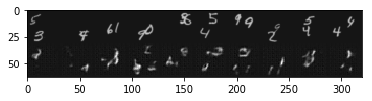

Epoch time  33.403615951538086
0.5208172798156738 346.2194519042969 180.83303833007812 0.5170748233795166


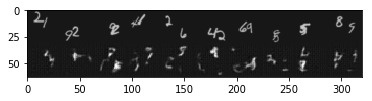

0.35733678936958313 340.456298828125 180.74407958984375 7.102357387542725


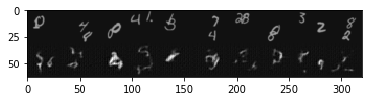

1.4835432767868042 309.197021484375 272.4658203125 6.9815168380737305


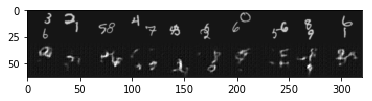

0.7418557405471802 274.07342529296875 239.27630615234375 6.977921962738037


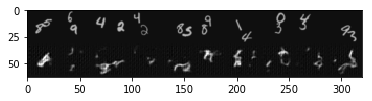

0.7060691118240356 252.51263427734375 199.9124298095703 6.985413551330566


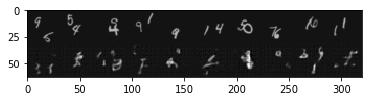

Epoch time  33.33196568489075
0.7702171802520752 254.84886169433594 187.26210021972656 0.4998323917388916


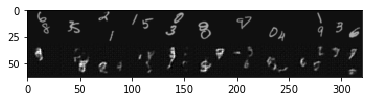

0.7420539259910583 209.4542694091797 186.9449920654297 7.85352349281311


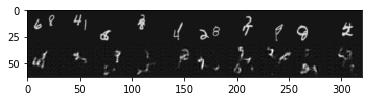

0.5406618714332581 217.82444763183594 180.83363342285156 8.657482385635376


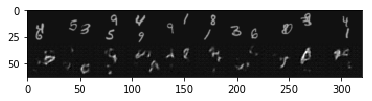

0.5527351498603821 191.3505096435547 179.29159545898438 7.09489369392395


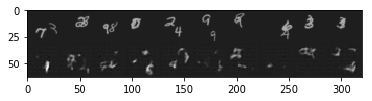

0.5314456820487976 186.2344512939453 183.995849609375 8.389187335968018


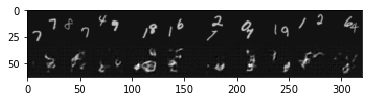

Epoch time  37.29510688781738
0.4889134168624878 171.6450958251953 220.94366455078125 0.6096949577331543


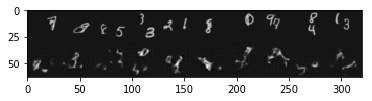

0.6562920808792114 157.9468536376953 184.96316528320312 7.049391269683838


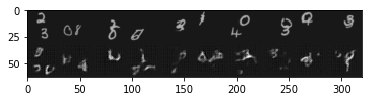

0.4558964669704437 153.31686401367188 188.60821533203125 6.967057466506958


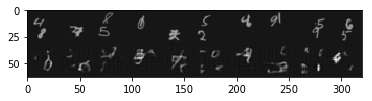

0.4253218173980713 143.15565490722656 182.4473114013672 6.9731059074401855


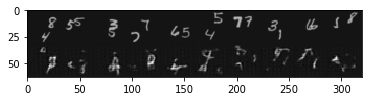

0.39777588844299316 136.12353515625 180.58059692382812 7.006266355514526


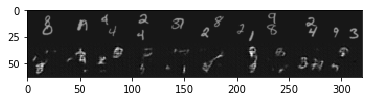

Epoch time  33.37388849258423
11.046258926391602 128.87115478515625 282.9856872558594 0.4960207939147949


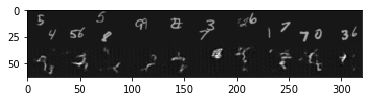

1.867937445640564 120.64222717285156 290.8341369628906 7.151267766952515


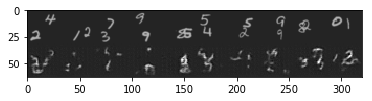

1.3530447483062744 111.58500671386719 294.15234375 6.990329027175903


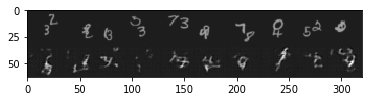

0.8666221499443054 109.71304321289062 264.15283203125 6.98697829246521


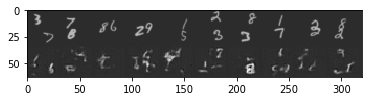

0.5331954956054688 103.49395751953125 260.9519348144531 6.982770919799805


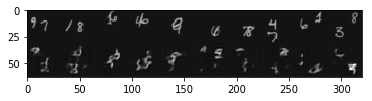

Epoch time  33.45392870903015
0.4443288743495941 98.10780334472656 256.0070495605469 0.5827486515045166


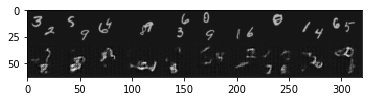

0.445502370595932 88.75700378417969 236.5938262939453 7.085371255874634


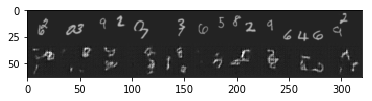

0.6827337145805359 87.41639709472656 198.7411651611328 6.982218980789185


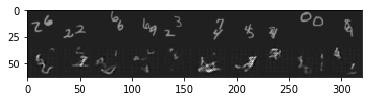

1.0986366271972656 78.70480346679688 203.22213745117188 6.989960193634033


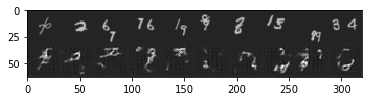

0.4775022864341736 74.33942413330078 180.33184814453125 7.026912212371826


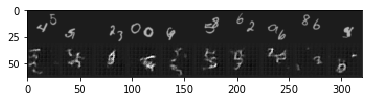

Epoch time  33.45278072357178


In [26]:
# Uncomment to initialize the VAE weights with a previous checkpoint (change the learning rates if this is done)
# checkpoint = torch.load('checkpoints/vae_e20.ckpt')
# encoder.load_state_dict(checkpoint['enc_state_dict'])
# decoder.load_state_dict(checkpoint['dec_state_dict'])

encoder_optimizer = optim.Adam(encoder.parameters())#, lr = 0.00001)
decoder_optimizer = optim.Adam(decoder.parameters())# , lr = 0.00001)
discriminator_optimizer = optim.Adam(discriminator.parameters())#, lr = 0.001)


l2_losses = []
kl_divergence = []
l_gan_losses = []
l_encoder_losses = []
l_decoder_losses = []

start = time.time()
start_epoch = time.time()

gamma = 1

for epoch in range(10):
    start = time.time()
    for i, data in enumerate(train_loader):

        # Zero grad all the optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()

        # Load Data
        data = data.to(device)
        y_real = torch.ones(data.shape[0]).to(device)
        y_fake = torch.zeros(data.shape[0]).to(device)
        
        # VAE
        mu, logvar = encoder(data)
        encoding = encoder.rsample(mu, logvar)
        
        # VAE output
        image_q_z = decoder(encoding)
        
        # Z sampled from Normal
        noise = torch.randn(encoding.shape).to(device)
        image_p_z = decoder(noise)
        
        # Discrimate on q_z, p_z, and data aka x
        disc_q_z, l_q_z  = discriminator(image_q_z)
        disc_p_z, l_p_z  = discriminator(image_p_z)
        disc_real, l_real  = discriminator(data)
        

        # l2 Loss of l'th layer of discrimator(q(z|x)) and discrimator(x)
        l2_loss = loss_function_mse(l_q_z, l_real)
        
        # KL divergence between mu, logvar sampled from p(z|x)
        kl = loss_function_kld(mu, logvar)
        
        # Compute all losses
        L_gan = F.binary_cross_entropy(disc_q_z, y_fake, reduction='sum') +  \
                F.binary_cross_entropy(disc_p_z, y_fake, reduction='sum') + \
                F.binary_cross_entropy(disc_real, y_real, reduction='sum')
        
        # decoder loss from VAE GAN paper
        L_decoder = l2_loss - L_gan 
        # Alternative formulation of decoder loss: instead
        # of minimizing likelihood of discriminator being correct,
        # maximize likelihood of discriminator being wrong.
        # L_decoder = l2_loss + F.binary_cross_entropy(disc_q_z, y_real, reduction='sum') + F.binary_cross_entropy(disc_p_z, y_real, reduction='sum')
        
        L_encoder = l2_loss + kl
        
        # Perform backprop in the order: Encoder, Decoder, Discriminator
        L_encoder.backward(retain_graph=True)
        encoder_optimizer.step()
        
        L_decoder.backward(retain_graph=True)
        decoder_optimizer.step()
        
        L_gan.backward(retain_graph=True)
        discriminator_optimizer.step()
        
        
        if i%100 == 0:
            
            l2_losses.append(l2_loss)
            kl_divergence.append(kl)
            l_gan_losses.append(L_gan.item())
            l_encoder_losses.append(L_encoder.item())
            l_decoder_losses.append(L_decoder.item())

            print(l2_loss.item(), kl.item(), L_gan.item(), time.time() - start)
            start = time.time()
            
            x_vis = np.concatenate(data[:,0,:,:][0:10].detach().cpu().numpy(), axis=1)
            g_vis = np.concatenate(image_q_z[:,0,:,:][0:10].detach().cpu().numpy(), axis=1)
            plt.imshow(np.concatenate( (x_vis, g_vis), axis=0), cmap='gray')
            plt.show()
    print("Epoch time ", time.time() - start_epoch)
    start_epoch = time.time()
        
